In [1]:
import mplhep
import numpy as np
import pandas as pd
import zfit

import tensorflow as tf
import uproot
from scipy.stats import expon, norm

import mplhep
import numpy as np

import zfit
from zfit import z

mplhep.style.use("LHCb2")
from matplotlib import pyplot as plt

/home/prozorov/install/miniconda3/envs/tf/lib/python3.11/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


In [2]:
trees = [uproot.open("/home/prozorov/dev/star/OUTPUT_2014_20012024.root:Jets"), ]

trees[0].keys()

['RunId',
 'centrality',
 'centr_weight',
 'NJet',
 'pseudorapidity',
 'jet_pt',
 'jet_pt_corr',
 'D0mass',
 'D0_r',
 'D0_pT',
 'lambda_1_1',
 'lambda_1_1half',
 'lambda_1_2',
 'lambda_1_3',
 'z']

In [3]:
with uproot.open("/home/prozorov/dev/star/OUTPUT_2014_20012024.root") as exp_file:
    exp_tree = exp_file['Jets']
    exp = exp_tree.arrays(["jet_pt_corr","pseudorapidity","D0mass", 
    "lambda_1_1", "lambda_1_1half", "lambda_1_2","lambda_1_3","z" , 
    "D0_r","D0_pT"
    
    
    ], cut="(D0mass > 1.75) & (D0mass<2.0) & (D0_pT > 1)",library='pd')
    exp.rename(columns={"jet_pt_corr": "pt", "D0mass":"mass"}, inplace=True)

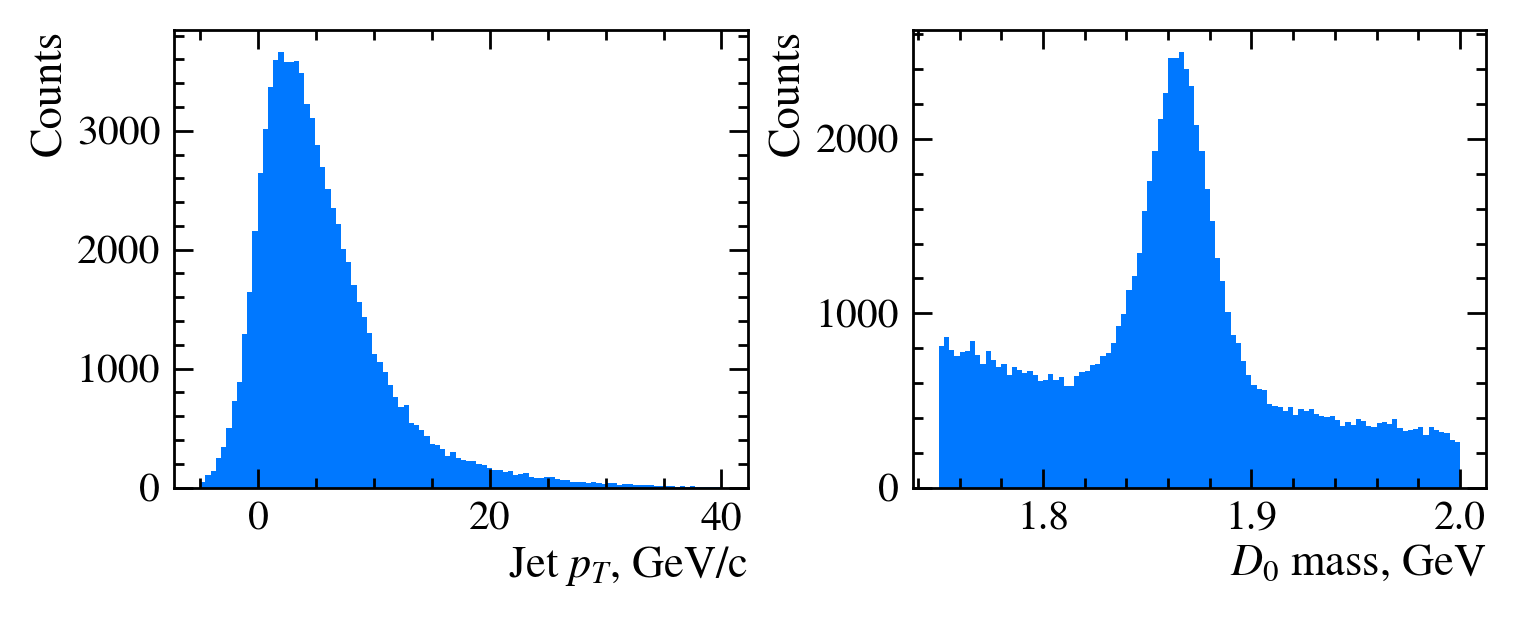

In [4]:
plt.figure(figsize=[15, 6])
plt.subplot(1, 2, 1)
plt.hist(exp['pt'], bins=100, range=(-5, 40))
plt.xlabel("Jet $p_T$, GeV/c")
plt.ylabel("Counts")
plt.subplot(1, 2, 2)
plt.hist(exp['mass'], bins=100, range=(1.75, 2.0))
plt.xlabel("$D_0$ mass, GeV")
plt.ylabel("Counts")
plt.show()

## ZFit tutorial


In [5]:
import zfit.z.numpy as znp
class CustomPDF(zfit.pdf.ZPDF):
    """1-dimensional PDF implementing the pol2 shape."""

    _PARAMS = ["par1","par2"]  # specify which parameters to take

    def _unnormalized_pdf(self, x):  # implement function
        data = z.unstack_x(x)
        par1 = self.params['par1']
        par2 = self.params['par2']
        return par1 * data + par2 * data**2

In [6]:
obs = zfit.Space('mass', limits=(1.75, 2.0))
mu = zfit.Parameter("mu", 1.865, 1.8, 1.92, step_size=0.0001)  # step_size is not mandatory but can be helpful
sigma = zfit.Parameter("sigma", 0.02, 0.001, 0.3, step_size=0.0001)  # it should be around the estimated uncertainty
lambd = zfit.Parameter("lambda", -3.0)

par1 = zfit.Parameter("par1", -10)
par2 = zfit.Parameter("par2", 5)

sig_yield = zfit.Parameter('sig_yield', 5300, 0, 100000,
                                step_size=10)  # step size: default is small, use appropriate
bkg_yield = zfit.Parameter('bkg_yield', 25000, 0, 3e5, step_size=10)

# model building, pdf creation
signal_pdf  = zfit.pdf.Gauss(mu=mu, sigma=sigma, obs=obs)
comb_bkg_pdf  = CustomPDF( par1=par1, par2=par2, obs=obs)


In [7]:

data= zfit.Data.from_pandas(exp)

# Create the extended models
extended_sig = signal_pdf.create_extended(sig_yield)
extended_bkg = comb_bkg_pdf.create_extended(bkg_yield)

# The final model is the combination of the signal and backgrond PDF
model = zfit.pdf.SumPDF([extended_bkg, extended_sig])

In [8]:
# plot the data
data_mass = data["mass"].numpy()
print ("data_mass shape = " + str(data_mass.shape))

# Builds the loss.
data_sw = zfit.Data.from_numpy(obs=obs, array=data_mass)
nll_sw = zfit.loss.ExtendedUnbinnedNLL(model, data_sw)

# This parameter was useful in the simultaneous fit but not anymore so we fix it.
sigma.floating = False

# Minimizes the loss.
minimizer = zfit.minimize.Minuit(use_minuit_grad=True)
result_sw = minimizer.minimize(nll_sw)
print(result_sw.params)


data_mass shape = (81004,)
name         value  (rounded)    at limit
---------  ------------------  ----------
bkg_yield             49969.7       False
sig_yield             31034.7       False
par1                 -10.3326       False
par2                  4.86474       False
mu                    1.86481       False


In [33]:
def plot_fit_projection(model, data, nbins=30, ax=None):
    # The function will be reused.
    if ax is None:
        ax = plt.gca()

    lower, upper = data.data_range.limit1d

    # Creates and histogram of the data and plots it with mplhep.
    counts, bin_edges = np.histogram(data.unstack_x(), bins=nbins)
    mplhep.histplot(counts, bins=bin_edges, histtype="errorbar", yerr=True,
                    label="Data", ax=ax, color="black")

    binwidth = np.diff(bin_edges)[0]
    x = np.linspace(lower, upper, num=1000)  # or np.linspace

    # Line plots of the total pdf and the sub-pdfs.
    y = model.ext_pdf(x) * binwidth
    ax.plot(x, y, label="total", color="royalblue")
    for m, l, c in zip(model.get_models(), ["background", "signal"], ["forestgreen", "crimson"]):
        ym = m.ext_pdf(x) * binwidth
        ax.plot(x, ym, label=l, color=c)

    # ax.set_title(data.data_range.obs[0])
    ax.set_xlim(lower, upper)
    ax.legend(fontsize=35)
    ax.set_xlabel("$D_0$ mass, GeV")
    ax.set_ylabel("Counts")

    # put stamp
    line_0=r'0 - 80\%'
    line_1=r'run14, Au-Au $\sqrt{s}=200$ GeV'
    line_2=r'$R=0.4$, $|\eta|<1-R$'
    line_3=r'$p_{T,D_0}>1$ GeV/c'

    ax.text(0.05, 0.95, line_0, ha='left', va='top', transform=ax.transAxes, fontsize=20)
    ax.text(0.05, 0.85, line_1, ha='left', va='top', transform=ax.transAxes, fontsize=20)
    ax.text(0.05, 0.75, line_2, ha='left', va='top', transform=ax.transAxes, fontsize=20)
    ax.text(0.05, 0.65, line_3, ha='left', va='top', transform=ax.transAxes, fontsize=20)


    plt.savefig("fit.pdf")
    return ax

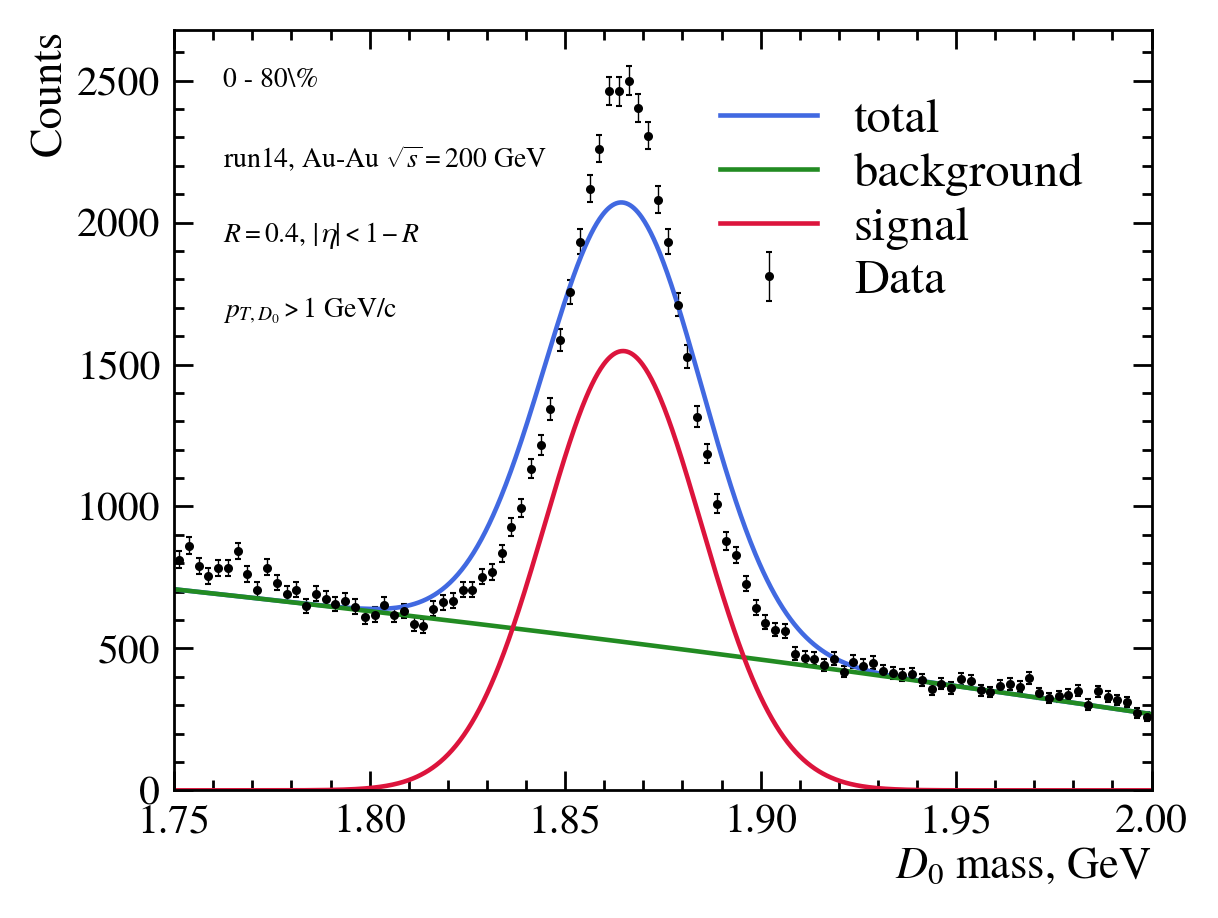

In [34]:
# Visualization of the result.
zfit.param.set_values(nll_sw.get_params(), result_sw)
ax=plot_fit_projection(model, data_sw, nbins=100)




In [11]:
from hepstats.splot import compute_sweights
weights = compute_sweights(model, data_sw)
print(weights)



{<zfit.Parameter 'bkg_yield' floating=True value=4.997e+04>: array([-0.20837968,  1.3001457 ,  1.48562954, ..., -0.13716001,
        1.48591609,  0.41280332]), <zfit.Parameter 'sig_yield' floating=True value=3.103e+04>: array([ 1.2083841 , -0.30014153, -0.4856254 , ...,  1.13716441,
       -0.48591195,  0.587201  ])}


In [12]:
data_pt =exp['pt'].to_numpy()
# data_pt=data_pt[(data_mass>mass_min_cut) & (data_mass<mass_max_cut)]
print ("data_pt shape = " + str(data_pt.shape))
print ("data_mass shape = " + str(data_mass.shape))

print ("weights shape = " + str(weights[sig_yield].shape))
print ("weights shape = " + str(weights[bkg_yield].shape))

print("Sum of signal sWeights: ", np.sum(weights[sig_yield]))
print("Sum of background sWeights: ", np.sum(weights[bkg_yield]))



data_pt shape = (81004,)
data_mass shape = (81004,)
weights shape = (81004,)
weights shape = (81004,)
Sum of signal sWeights:  31034.6846156926
Sum of background sWeights:  49969.66199883398


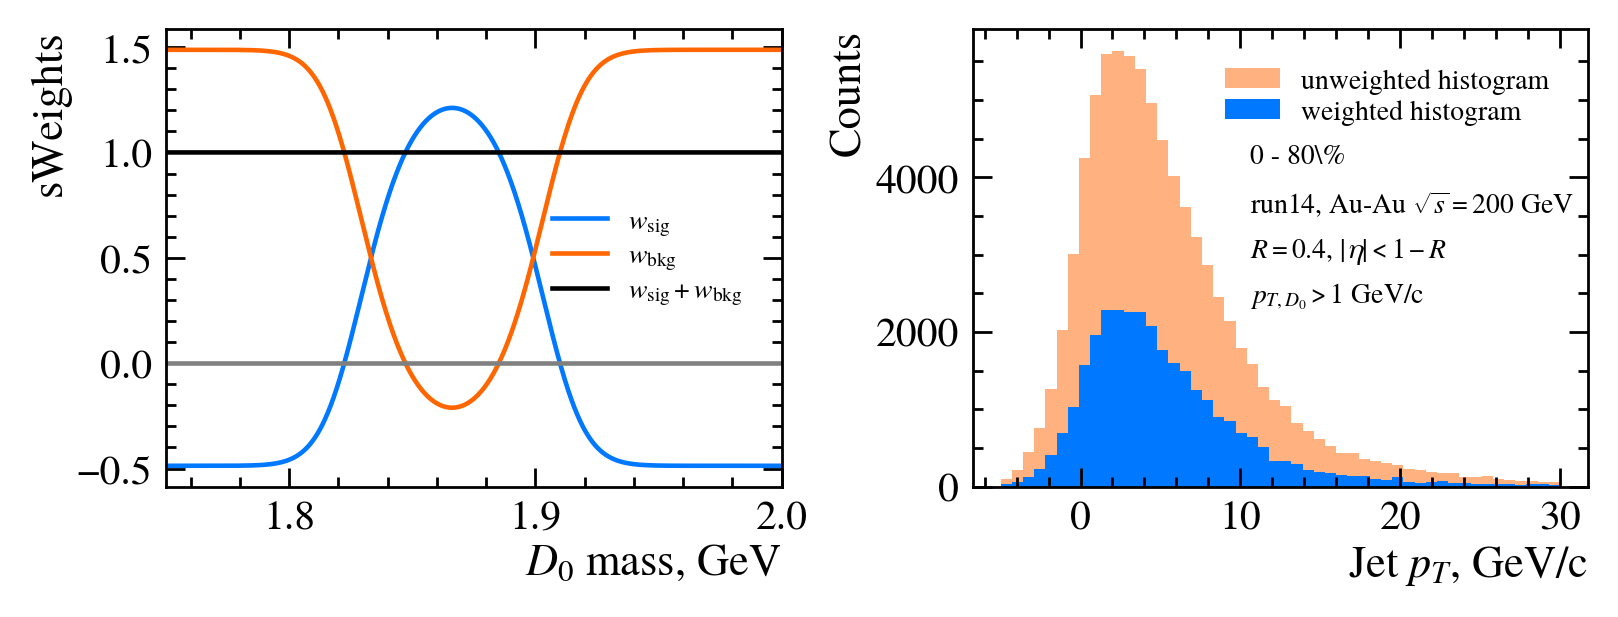

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
nbins = 50


sorter = data_mass.argsort()

axs[0].plot(data_mass[sorter], weights[sig_yield][sorter], label="$w_\\mathrm{sig}$")
axs[0].plot(data_mass[sorter], weights[bkg_yield][sorter], label="$w_\\mathrm{bkg}$")
axs[0].plot(data_mass[sorter], weights[sig_yield][sorter] + weights[bkg_yield][sorter],
            "-k", label="$w_\\mathrm{sig} + w_\\mathrm{bkg}$")
axs[0].axhline(0, color="0.5")
axs[0].legend(fontsize=20)
axs[0].set_xlim(1.75, 2.0)
axs[0].set_xlabel("$D_{0}$ mass, GeV")
axs[0].set_ylabel("sWeights")



axs[1].hist(data_pt, bins=nbins, range=(-5, 30),color="C1"  ,  label="unweighted histogram", alpha=.5)
axs[1].hist(data_pt, bins=nbins, range=(-5, 30),color="C0", weights=weights[sig_yield], label="weighted histogram", alpha=1)

axs[1].set_xlabel("Jet $p_T$, GeV/c")
axs[1].set_ylabel("Counts")
axs[1].legend(fontsize=20)

#  put stamp on [1] plot
line_0=r'0 - 80\%'
line_1=r'run14, Au-Au $\sqrt{s}=200$ GeV'
line_2=r'$R=0.4$, $|\eta|<1-R$'
line_3=r'$p_{T,D_0}>1$ GeV/c'

axs[1].text(0.45, 0.75, line_0, ha='left', va='top', transform=axs[1].transAxes, fontsize=20)
axs[1].text(0.45, 0.65, line_1, ha='left', va='top', transform=axs[1].transAxes, fontsize=20)
axs[1].text(0.45, 0.55, line_2, ha='left', va='top', transform=axs[1].transAxes, fontsize=20)
axs[1].text(0.45, 0.45, line_3, ha='left', va='top', transform=axs[1].transAxes, fontsize=20)

fig.savefig("sWeights.pdf")






In [14]:
corr = exp.corr()
# Fill diagonal and upper half with NaNs
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(color='#f1f1f1')  # Color NaNs grey
 .format(precision=3))

 


,pt,pseudorapidity,mass,lambda_1_1,lambda_1_1half,lambda_1_2,lambda_1_3,z,D0_r,D0_pT
pt,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
pseudorapidity,0.033,nan,nan,nan,nan,nan,nan,nan,nan,nan
mass,0.007,0.007,nan,nan,nan,nan,nan,nan,nan,nan
lambda_1_1,0.005,-0.002,0.002,nan,nan,nan,nan,nan,nan,nan
lambda_1_1half,0.005,-0.002,0.002,0.998,nan,nan,nan,nan,nan,nan
lambda_1_2,0.005,-0.002,0.001,0.992,0.998,nan,nan,nan,nan,nan
lambda_1_3,0.004,-0.002,0.000,0.974,0.987,0.995,nan,nan,nan,nan
z,-0.008,0.000,-0.003,-0.861,-0.854,-0.844,-0.824,nan,nan,nan
D0_r,0.152,0.023,0.031,-0.004,-0.004,-0.004,-0.004,0.005,nan,nan
D0_pT,0.169,0.007,0.007,0.005,0.005,0.005,0.004,-0.005,-0.394,nan


(array([-395.54503024, -420.3879338 , -384.82708135, -367.7762999 ,
        -379.95140997, -382.86860195, -410.13587901, -370.17598259,
        -345.79294763, -381.77566563, -356.36058006, -336.25153277,
        -343.7799923 , -314.70339918, -335.89207888, -326.15032112,
        -314.94433816, -318.71481099, -305.19664336, -283.31963444,
        -279.44886542, -284.33925357, -253.79865928, -240.29996449,
        -197.88010555, -165.51473064, -139.28687163,  -90.74787175,
         -28.24075336,   40.75003085,  122.58097728,  220.58573954,
         316.26715707,  437.80137673,  589.69660997,  733.07213363,
         937.22677946, 1101.91739724, 1313.53649573, 1643.79284362,
        1906.43971406, 2177.00889118, 2450.75684928, 2672.59283511,
        2951.49846582, 2976.72022347, 3027.90564469, 2903.19039786,
        2760.80519054, 2455.50394231, 2231.45967123, 1922.08677415,
        1652.14101435, 1358.18099068, 1153.22866393,  910.70373189,
         720.58587904,  604.7799294 ,  457.15732

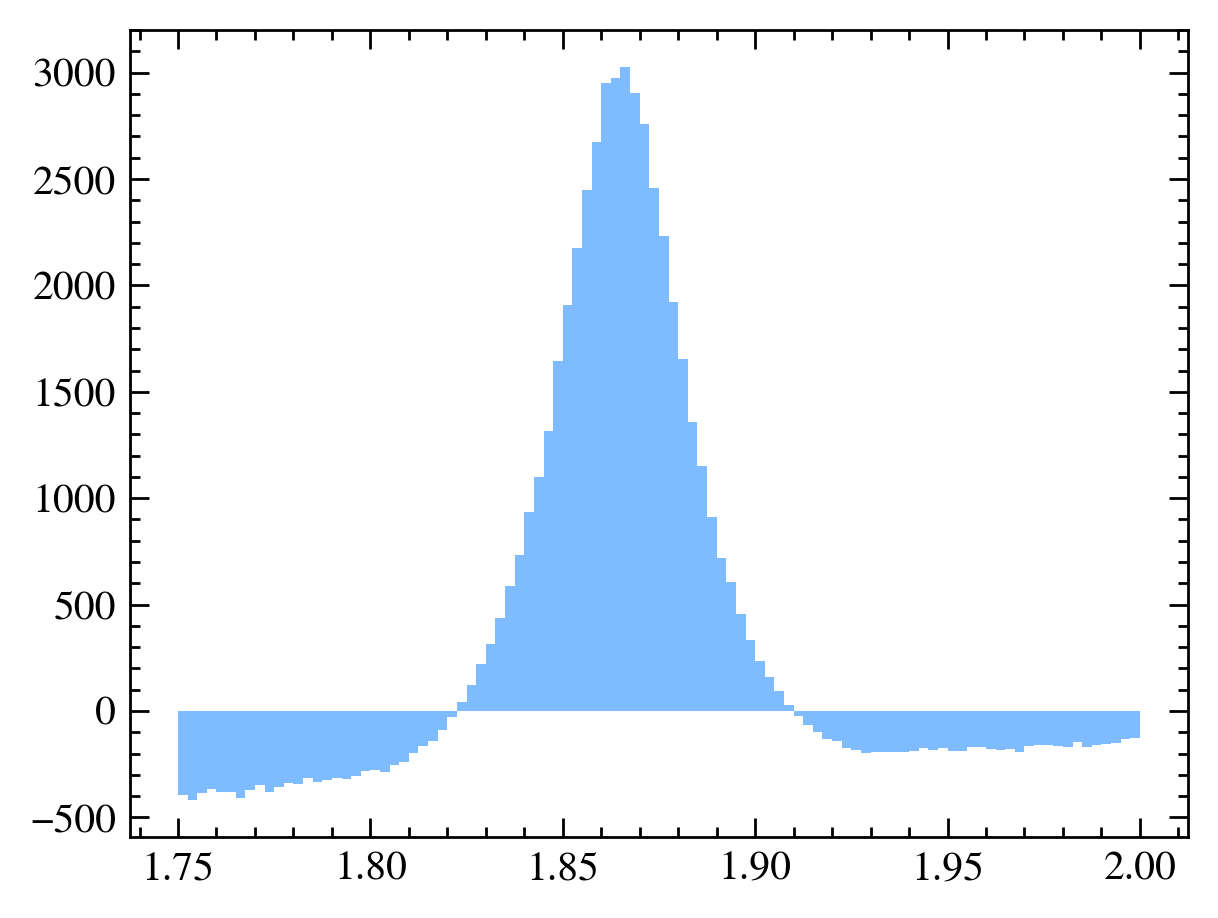

In [15]:
# plot(data_mass, bins=nbins, range=(0, 40), weights=weights[sig_yield], label="weighted histogram", alpha=.5)

plt.hist(data_mass, bins=100, range=(1.75, 2.0), weights=weights[sig_yield], label="weighted histogram", alpha=.5)